# Evaluation using Greedy Maximum Reward Search

It can be usefull to see, what behavior we encourage our models to learn. Therefor we can analyze, how an optimal agent would behave, that always chooses the action with the highest reward function. 


In [1]:
import gymnasium as gym
import numpy as np  
import matplotlib.pyplot as plt
from itertools import count
import matplotlib
from pprint import pprint
from copy import deepcopy

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
def get_best_action(env):
    rewards = []
    for action in range(env.action_space.n):
        rewards.append(env.unwrapped._reward(action))
    return np.argmax(rewards)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


episode: 0, total reward: 15.333, average_reward: 15.333, length: 19
episode: 1, total reward: 15.999, average_reward: 15.666, length: 20
episode: 2, total reward: 1.765, average_reward: 11.032, length: 2
episode: 3, total reward: 2.565, average_reward: 8.916, length: 3
episode: 4, total reward: 7.199, average_reward: 8.572, length: 9
episode: 5, total reward: 12.032, average_reward: 9.149, length: 15
episode: 6, total reward: 8.000, average_reward: 8.985, length: 10
episode: 7, total reward: 21.599, average_reward: 10.562, length: 27
episode: 8, total reward: 19.199, average_reward: 11.521, length: 24
episode: 9, total reward: 12.799, average_reward: 11.649, length: 16
episode: 10, total reward: 11.199, average_reward: 11.236, length: 14
episode: 11, total reward: 1.632, average_reward: 9.799, length: 2
episode: 12, total reward: 3.199, average_reward: 9.943, length: 4
episode: 13, total reward: 7.232, average_reward: 10.409, length: 9
episode: 14, total reward: 12.000, average_reward

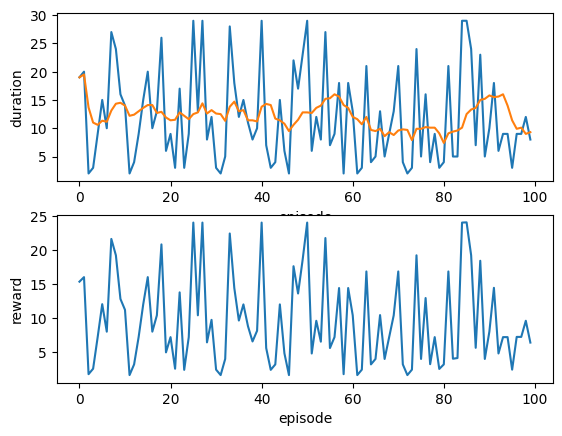

In [3]:
max_episode_num = 100

env = gym.make("highway-fast-v0")
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state, info = env.reset()
    reward_sum = list()
    for t in count():
        best_action = get_best_action(env)
        new_state, reward, done, truncated, info = env.step(best_action)
        reward_sum.append(reward)
        # env.render()
        if done or truncated:
            numsteps.append(t)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(reward_sum))
            print(f"episode: {episode}, total reward: {all_rewards[-1]:.3f}, average_reward: {np.mean(all_rewards[-10:]):.3f}, length: {t}")
            break
        state = new_state
# env.close()        
plt.subplot(2,1,1)
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.ylabel('duration')
plt.xlabel('episode')
plt.subplot(2,1,2)
plt.plot(all_rewards)
plt.ylabel('reward')
plt.xlabel('episode')

plt.show()

Unfortunately, this looks very bad... The optimal policy should always run for the maximal duration.

The explanation for this error lies in the implementation of th the _rewards() function of the `highway-env`. In it the rewards are calculated for the current state of the env only. The action parameter is not used.

In [4]:
def _rewards(self, action):
    '''
        taken from https://github.com/Farama-Foundation/HighwayEnv/blob/master/highway_env/envs/highway_env.py
    '''
    neighbours = self.road.network.all_side_lanes(self.vehicle.lane_index)
    lane = self.vehicle.target_lane_index[2] if isinstance(self.vehicle, ControlledVehicle) \
        else self.vehicle.lane_index[2]
    # Use forward speed rather than speed, see https://github.com/eleurent/highway-env/issues/268
    forward_speed = self.vehicle.speed * np.cos(self.vehicle.heading)
    scaled_speed = utils.lmap(forward_speed, self.config["reward_speed_range"], [0, 1])
    return {
        "collision_reward": float(self.vehicle.crashed),
        "right_lane_reward": lane / max(len(neighbours) - 1, 1),
        "high_speed_reward": np.clip(scaled_speed, 0, 1),
        "on_road_reward": float(self.vehicle.on_road)
    }

We can created an inefficient lookahead policy, that executes each action in a copy of the environment while leaving the original environment unchanged.

In [5]:
def get_best_action_by_copy(env):
    rewards = []
    for action in range(env.action_space.n):
        env_copy = deepcopy(env)
        _, reward, _, _,_ = env_copy.step(action)
        rewards.append(reward)
    return np.argmax(rewards)

/home/aai/anaconda3/envs/q-learning/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


episode: 0, total reward: 13.979, average_reward: 13.979, length: 14
episode: 1, total reward: 16.877, average_reward: 15.428, length: 17
episode: 2, total reward: 29.777, average_reward: 20.211, length: 29
episode: 3, total reward: 29.845, average_reward: 22.619, length: 29
episode: 4, total reward: 9.046, average_reward: 19.905, length: 9
episode: 5, total reward: 2.047, average_reward: 16.929, length: 2
episode: 6, total reward: 5.779, average_reward: 15.336, length: 6
episode: 7, total reward: 11.878, average_reward: 14.903, length: 12
episode: 8, total reward: 20.709, average_reward: 15.549, length: 21
episode: 9, total reward: 11.017, average_reward: 15.095, length: 11
episode: 10, total reward: 14.197, average_reward: 15.117, length: 14
episode: 11, total reward: 13.932, average_reward: 14.823, length: 14
episode: 12, total reward: 15.845, average_reward: 13.430, length: 16
episode: 13, total reward: 9.879, average_reward: 11.433, length: 10
episode: 14, total reward: 3.046, ave

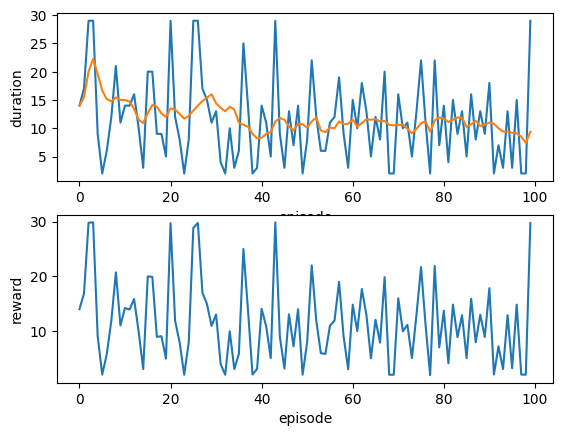

In [6]:
max_episode_num = 100

env = gym.make("highway-fast-v0")
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state, info = env.reset()
    reward_sum = list()
    for t in count():
        best_action = get_best_action_by_copy(env)
        new_state, reward, done, truncated, info = env.step(best_action)
        reward_sum.append(reward)
        # env.render()
        if done or truncated:
            numsteps.append(t)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(reward_sum))
            print(f"episode: {episode}, total reward: {all_rewards[-1]:.3f}, average_reward: {np.mean(all_rewards[-10:]):.3f}, length: {t}")
            break
        state = new_state
# env.close()        
plt.subplot(2,1,1)
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.ylabel('duration')
plt.xlabel('episode')
plt.subplot(2,1,2)
plt.plot(all_rewards)
plt.ylabel('reward')
plt.xlabel('episode')

plt.show()

3